In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math

In [19]:
train_data = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
test_data = pd.read_csv('/kaggle/input/UBC-OCEAN/test.csv')

In [20]:
final_combined_data = pd.read_csv('/kaggle/input/final-combined/final_combined_data.csv')

## Extract Features From TILES with at least 70% Tissue

### Prepare Data for Feature Extraction
##### 55 whole slide images (balanced dataset)

In [21]:
# Number of samples per label category
samples_per_label = 11  # 11 images * 5 classes = 55 WSI images

# Filter out the rows where is_tma is False
filtered_data = final_combined_data[final_combined_data['is_tma'] == False]

# Sample images in a balanced manner
balanced_samples = filtered_data.groupby('label').apply(lambda x: x.sample(samples_per_label)).reset_index(drop=True)

#### no need to do extraction.  load below

In [ ]:
###
###
###           MAY PASS ON THIS STEP !!!          ###
###
###

import cv2
import timm
import torch
from torchvision import transforms
from PIL import Image, ImageFile

# Increase the maximum number of pixels PIL can process
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Select the first 55 WSI images 
selected_images = balanced_samples

# Load a pre-trained model for feature extraction
model = timm.create_model('resnet50', pretrained=True, num_classes=0)
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
# Function to check if the tile has tissue present
def is_tissue_present(tile, area_threshold=0.7, low_saturation_threshold=20):   # 70% tissue
    hsv = cv2.cvtColor(tile, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    _, high_sat = cv2.threshold(s, low_saturation_threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    tissue_mask = cv2.dilate(high_sat, kernel, iterations=2)
    tissue_mask = cv2.erode(tissue_mask, kernel, iterations=2)
    tissue_ratio = np.sum(tissue_mask > 0) / (tile_size * tile_size)
    return tissue_ratio > area_threshold

# Function to extract features from a tile
def extract_features(tile, model, transform):
    tile = Image.fromarray(tile)
    tile = transform(tile).unsqueeze(0)
    with torch.no_grad():
        features = model(tile)
    return features.squeeze(0).numpy()

# Define the size for the tiles
tile_size = 512

slide_features = {}

# Function to process a patch of the image
def process_patch(patch, model, transform):
    if is_tissue_present(patch):
        features = extract_features(patch, model, transform)
        return features
    return None

# Process each image, extract tiles, extract features, and store them
total_images = len(selected_images)
for index, row in enumerate(selected_images.iterrows()):
    image_path = row[1]['path']
    label = row[1]['label']
    tile_features = []  # List to hold the features for the current image

     # Print the current status
    print(f"Processing image {index + 1} of {total_images}: {image_path}")

    # Open the image using Pillow
    with Image.open(image_path) as img:
        for y in range(0, img.height, tile_size):
            for x in range(0, img.width, tile_size):
                # Read the patch
                patch = img.crop((x, y, x + tile_size, y + tile_size))
                patch = np.array(patch)  # Convert PIL Image to NumPy array

                # Process the patch
                features = process_patch(patch, model, transform)
                if features is not None:
                    tile_features.append(features)

    # Store the extracted features and the label in the slide_features dictionary
    slide_features[image_path] = {
        'features': tile_features,
        'label': label
    }

# Now slide_features contains the feature vectors and labels for each of the 55 slides

#### save & load extracted features

In [ ]:
import pickle

with open('/kaggle/working/512px_resnet50_5_slide_features.pkl', 'wb') as f:
    pickle.dump(slide_features, f)

In [22]:
import pickle

with open('/kaggle/input/slide-features55/512px_resnet50_55_slide_features.pkl', 'rb') as f:
    slide_features = pickle.load(f)

----------------------------------------------------------

### Splitting data into train, validation and test sets

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random

# Convert slide_features to a suitable format
data = [(features['features'], features['label']) for path, features in slide_features.items()]

# Organize data by labels
data_by_label = defaultdict(list)
for features, label in data:
    data_by_label[label].append((features, label))

# Split data for each label into train, validation, and test
train_data = []
val_data = []
test_data = []

for label, label_data in data_by_label.items():
    # Split data for this label into train and test
    train_val_label_data, test_label_data = train_test_split(label_data, test_size=0.2)
    
    # Split train data into train and validation
    train_label_data, val_label_data = train_test_split(train_val_label_data, test_size=0.25)  # 0.25 x 0.8 = 0.2 of original
    
    # Append split data to respective sets
    train_data.extend(train_label_data)
    val_data.extend(val_label_data)
    test_data.extend(test_label_data)

# Shuffle the datasets
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# Function to check balance in each set
def check_balance(dataset):
    label_counts = defaultdict(int)
    for _, label in dataset:
        label_counts[label] += 1
    return dict(label_counts)

# Display balance of each set
print("Train balance:", check_balance(train_data))
print("Validation balance:", check_balance(val_data))
print("Test balance:", check_balance(test_data))

Train balance: {'CC': 6, 'EC': 6, 'MC': 6, 'LGSC': 6, 'HGSC': 6}
Validation balance: {'MC': 2, 'EC': 2, 'HGSC': 2, 'LGSC': 2, 'CC': 2}
Test balance: {'HGSC': 3, 'LGSC': 3, 'EC': 3, 'CC': 3, 'MC': 3}


### Visualize clusters for training data feature vectors 

In [24]:
train_features = []
train_labels = []

# Iterate over the training data to aggregate features and labels
for bag, label in train_data:
    for feature_vector in bag:
        train_features.append(feature_vector)
        train_labels.append(label)

# Convert to NumPy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

In [25]:
import umap.umap_ as umap
import hdbscan

# UMAP on training data features
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')
umap_embedding_train = umap_reducer.fit_transform(train_features)

In [26]:
# Adjust HDBSCAN parameters
min_cluster_size = 5  # Increase for larger minimum cluster size
min_samples = 10  # Increase to reduce noise
epsilon = 0.19  # Adjust based on distance threshold
alpha = 1.0  # Adjust density threshold for cluster formation

# Clustering with HDBSCAN
cluster_labels_train = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon,
                                       alpha=alpha, gen_min_span_tree=True).fit_predict(umap_embedding_train)

In [27]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
score = silhouette_score(umap_embedding_train, cluster_labels_train)
print("Silhouette Score: ", score)

Silhouette Score:  -0.14079541


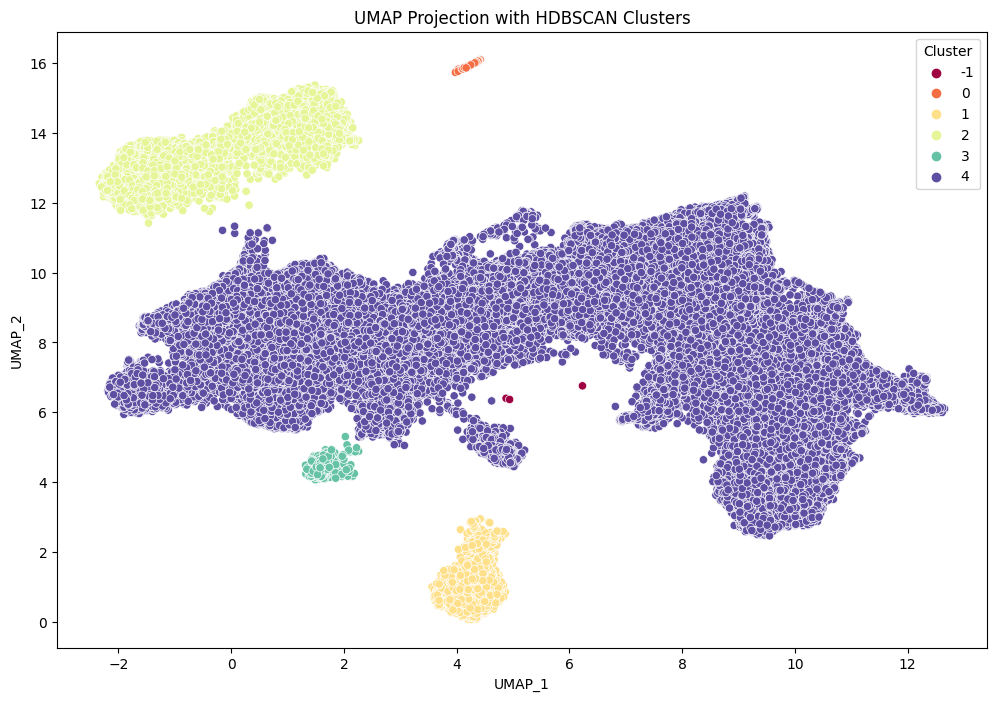

In [28]:
# Convert the UMAP embedding and cluster labels to a pandas DataFrame for plotting
columns = [f'UMAP_{i+1}' for i in range(umap_embedding_train.shape[1])]
embedding_df_train = pd.DataFrame(umap_embedding_train, columns=columns)
embedding_df_train['Cluster'] = cluster_labels_train

# Plot using Seaborn's scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=embedding_df_train, x='UMAP_1', y='UMAP_2', hue='Cluster', palette='Spectral')
plt.title("UMAP Projection with HDBSCAN Clusters")
plt.show()

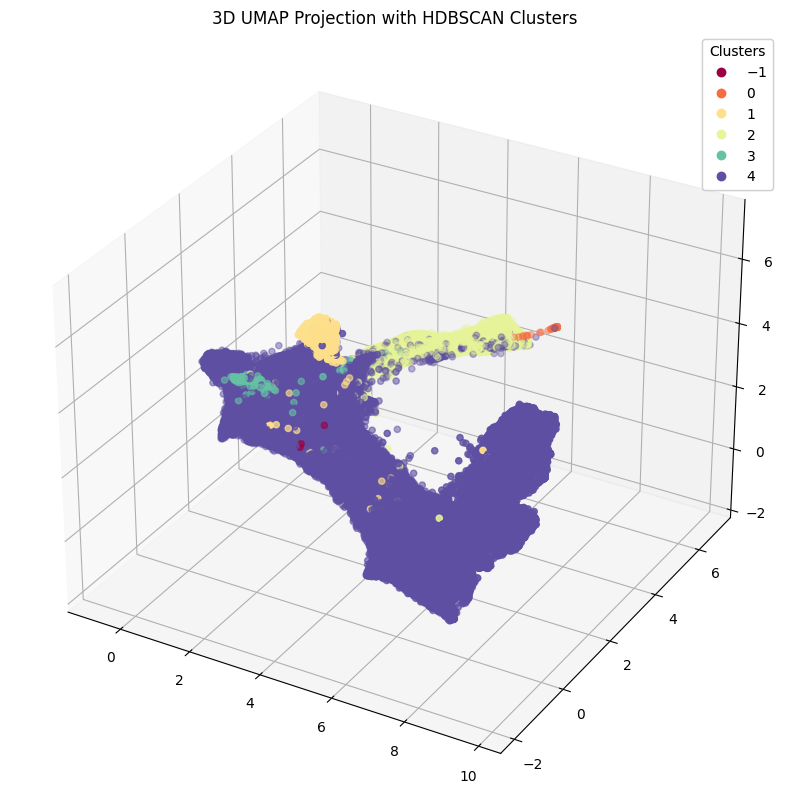

In [29]:
from mpl_toolkits.mplot3d import Axes3D

# Create a UMAP instance for 3D projection
umap_3d = umap.UMAP(n_neighbors=50, n_components=3, min_dist=0.01, metric='cosine')
umap_embedding_3d = umap_3d.fit_transform(train_features)

# Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(umap_embedding_3d[:, 0], umap_embedding_3d[:, 1], umap_embedding_3d[:, 2], c=cluster_labels_train, cmap='Spectral')
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.title("3D UMAP Projection with HDBSCAN Clusters")
plt.show()

In [30]:
from sklearn.metrics import silhouette_samples

# Assume umap_embedding_train is your UMAP reduced features and cluster_labels_train are the HDBSCAN labels
silhouette_vals = silhouette_samples(umap_embedding_train, cluster_labels_train)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({'Silhouette': silhouette_vals, 'Cluster': cluster_labels_train})

# Group by Cluster and calculate mean silhouette value for each cluster
cluster_avg_silhouette = df.groupby('Cluster')['Silhouette'].mean()

# Print average silhouette score for each cluster
for cluster, score in cluster_avg_silhouette.items():
    print(f"Cluster {cluster} average silhouette score: {score:.4f}")

Cluster -1 average silhouette score: 0.7689
Cluster 0 average silhouette score: 0.9722
Cluster 1 average silhouette score: 0.8213
Cluster 2 average silhouette score: 0.5653
Cluster 3 average silhouette score: 0.9338
Cluster 4 average silhouette score: -0.2948


Cluster -1 label distribution:
Original_Label
CC      1
MC      1
LGSC    1
Name: count, dtype: int64



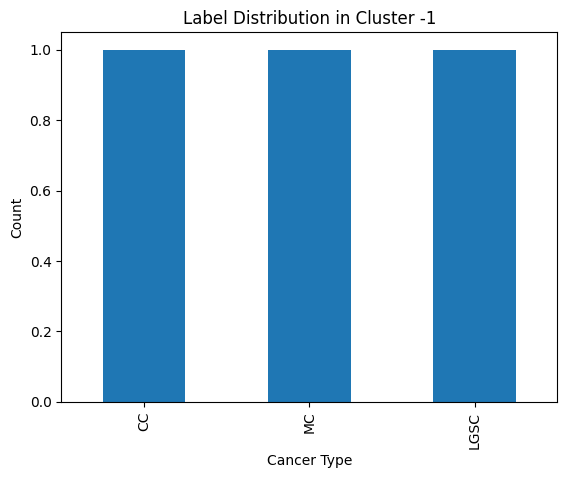

Cluster 0 label distribution:
Original_Label
EC    74
Name: count, dtype: int64



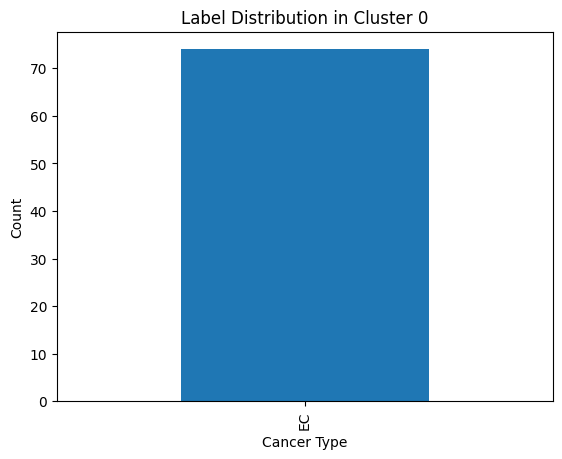

Cluster 1 label distribution:
Original_Label
CC      3514
EC        32
HGSC       9
MC         4
Name: count, dtype: int64



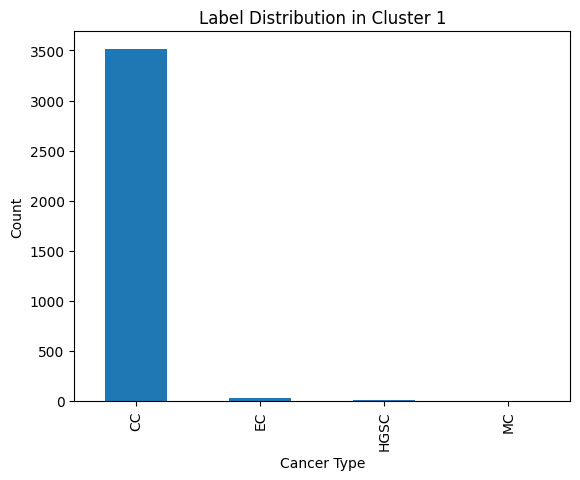

Cluster 2 label distribution:
Original_Label
EC      7040
HGSC     293
MC        92
CC        87
LGSC      59
Name: count, dtype: int64



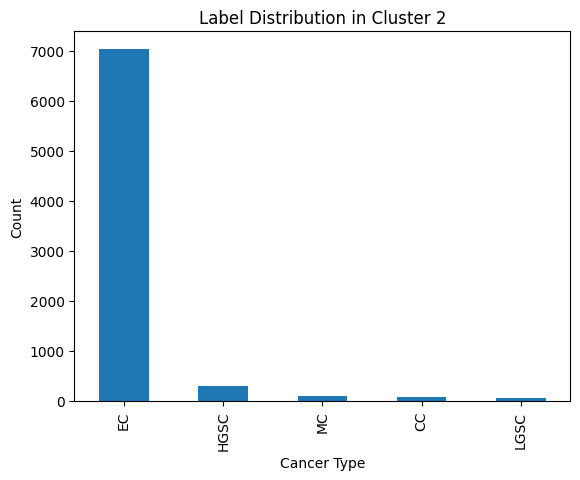

Cluster 3 label distribution:
Original_Label
CC      757
LGSC     11
EC       10
MC        8
HGSC      4
Name: count, dtype: int64



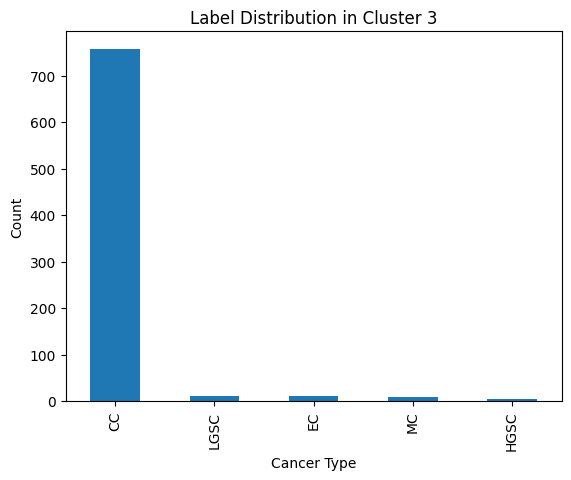

In [32]:
# Create a DataFrame with UMAP embeddings, HDBSCAN cluster labels, and original labels
embedding_df_train['Original_Label'] = train_labels

# Analyze the labels for each cluster
for cluster in range(-1, 4):  # Assuming clusters are numbered 0 to 4
    cluster_data_train = embedding_df_train[embedding_df_train['Cluster'] == cluster]
    label_counts = cluster_data_train['Original_Label'].value_counts()
    print(f"Cluster {cluster} label distribution:\n{label_counts}\n")

    # Optionally, create a bar plot for each cluster's label distribution
    label_counts.plot(kind='bar')
    plt.title(f"Label Distribution in Cluster {cluster}")
    plt.xlabel("Cancer Type")
    plt.ylabel("Count")
    plt.show()

### Using cluster knowledge in training data

In [34]:
####
####  OLD APPROACH
####

from collections import defaultdict
import numpy as np

num_representatives = 10 # Number of representatives to select from each cluster
representative_features = defaultdict(list)

# Clusters to exclude
excluded_clusters = [5, 6, 8, 9, 10]

# Iterating through unique clusters
for cluster in np.unique(cluster_labels_train):
    if cluster not in excluded_clusters:
        cluster_indices = np.where(cluster_labels_train == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, num_representatives)
        for idx in selected_indices:
            representative_features[cluster].append(train_features[idx])

# representative_features now holds the selected feature vectors for each cluster

augmented_train_data = []

for bag_features, label in train_data:
    augmented_bag = bag_features.copy()

    # Add representatives from each cluster to the bag
    for cluster_reps in representative_features.values():
        augmented_bag.extend(cluster_reps)
    
    augmented_train_data.append((augmented_bag, label))
    
####  OLD APPROACH

In [35]:
# Set thresholds for exclusion
silhouette_threshold = 0.6  # Threshold for silhouette score
homogeneity_max = 1  # Threshold max class dominance in cluster
homogeneity_min = 0.7 # Threshold min class dominance in cluster
minimum_cluster_size = 60  # Minimum number of samples in a cluster

excluded_clusters = []

# Analyze each cluster to decide on exclusion
for cluster in np.unique(cluster_labels_train):
    cluster_indices = np.where(cluster_labels_train == cluster)[0]
    cluster_silhouette_score = cluster_avg_silhouette[cluster]

    # Calculate label homogeneity
    label_counts = defaultdict(int)
    for idx in cluster_indices:
        label_counts[train_labels[idx]] += 1
    max_label_proportion = max(label_counts.values()) / sum(label_counts.values())

    # Check conditions for exclusion
    if (cluster_silhouette_score < silhouette_threshold or
        max_label_proportion > homogeneity_max or
        max_label_proportion < homogeneity_min or
        len(cluster_indices) < minimum_cluster_size):
        excluded_clusters.append(cluster)

print("Excluded Clusters:", excluded_clusters)

Excluded Clusters: [-1, 2, 4]


In [36]:
from collections import defaultdict

# Set the base number of representatives per cluster
base_representatives = 12

representative_features = defaultdict(list)

# Function to calculate proportional representatives
def calculate_proportional_representatives(class_distribution, total_representatives):
    total_count = sum(class_distribution.values())
    proportional_representatives = {}
    for class_label, count in class_distribution.items():
        proportional_count = int((count / total_count) * total_representatives)
        proportional_representatives[class_label] = proportional_count
    return proportional_representatives

# Iterate through each cluster
for cluster in np.unique(cluster_labels_train):
    if cluster not in excluded_clusters:
        cluster_indices = np.where(cluster_labels_train == cluster)[0]
        print("")
        # Get class distribution in actual counts
        class_distribution = defaultdict(int)
        for idx in cluster_indices:
            class_distribution[train_labels[idx]] += 1

        # Adjust the number of representatives based on cluster silhouette score
        silhouette_score = cluster_avg_silhouette[cluster]
        adjusted_representatives = int(base_representatives * max(0.5, silhouette_score))

        # Calculate proportional representatives
        proportional_representatives = calculate_proportional_representatives(class_distribution, adjusted_representatives)

        # Print class distribution and number of representatives
        print(f"Cluster {cluster}: Class Distribution - {dict(class_distribution)}")
        print(f"  Proportional Representatives: {proportional_representatives}")

        # Select and add representatives
        for class_label, num_reps in proportional_representatives.items():
            class_indices = [i for i in cluster_indices if train_labels[i] == class_label]
            selected_indices = np.random.choice(class_indices, num_reps, replace=True)

            for idx in selected_indices:
                representative_features[cluster].append(train_features[idx])

            # Print the number of representatives added for each class
            print(f"  Adding {num_reps} for class {class_label}")

# representative_features now contains the selected feature vectors for each cluster


Cluster 0: Class Distribution - {'EC': 74}
  Proportional Representatives: {'EC': 11}
  Adding 11 for class EC

Cluster 1: Class Distribution - {'CC': 3514, 'MC': 4, 'HGSC': 9, 'EC': 32}
  Proportional Representatives: {'CC': 8, 'MC': 0, 'HGSC': 0, 'EC': 0}
  Adding 8 for class CC
  Adding 0 for class MC
  Adding 0 for class HGSC
  Adding 0 for class EC

Cluster 3: Class Distribution - {'LGSC': 11, 'CC': 757, 'EC': 10, 'HGSC': 4, 'MC': 8}
  Proportional Representatives: {'LGSC': 0, 'CC': 10, 'EC': 0, 'HGSC': 0, 'MC': 0}
  Adding 0 for class LGSC
  Adding 10 for class CC
  Adding 0 for class EC
  Adding 0 for class HGSC
  Adding 0 for class MC


In [37]:
# Augmenting the training data with representatives
augmented_train_data = []

for bag_features, label in train_data:
    augmented_bag = bag_features.copy()

    # Add representatives from each cluster to the bag
    for cluster_reps in representative_features.values():
        augmented_bag.extend(cluster_reps)

    augmented_train_data.append((augmented_bag, label))

# Optional: Print out the distribution of the number of representatives per cluster
for cluster, reps in representative_features.items():
    print(f"Cluster {cluster}: {len(reps)} representatives added")

Cluster 0: 11 representatives added
Cluster 1: 8 representatives added
Cluster 3: 10 representatives added


## Multiple Instance Learning (MIL) classifier

In [38]:
# Create a mapping from label strings to integers
unique_labels = sorted(set(label for _, label in data))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

class MILDataset(Dataset):
    def __init__(self, data, label_to_idx):
        self.data = data
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_vectors, label = self.data[idx]
        label_idx = self.label_to_idx[label]  # Convert label to integer
        return torch.tensor(feature_vectors), torch.tensor(label_idx, dtype=torch.float32)

# Creating the datasets with augmented training data
train_dataset = MILDataset(augmented_train_data, label_to_idx)
val_dataset = MILDataset(val_data, label_to_idx)
test_dataset = MILDataset(test_data, label_to_idx)

# DataLoaders remain the same
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [39]:
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


class AttentionMIL(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(AttentionMIL, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim) # Batch normalization
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=0)
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, bag):
        # h = self.bn1(torch.relu(self.fc1(bag)))  # Batch normalization
        h = torch.relu(self.fc1(bag))
        a = self.attention(h)
        v = torch.sum(a * h, dim=0)
        y = self.classifier(v)
        return y, a

# Number of unique classes
num_classes = len(unique_labels)

model = AttentionMIL(input_dim=2048, hidden_dim=512, num_classes=num_classes)
loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early Stopping Parameters
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Model Training with Validation
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Training loop
    for bags, labels in train_loader:
        optimizer.zero_grad()
        bags = bags.squeeze(0)  # Remove the extra dimension from bags
        labels = labels.squeeze(0).long()  # Remove extra dimension and ensure long type for labels
        output, _ = model(bags)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 0)
        train_total += 1
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.squeeze(0)
            labels = labels.squeeze(0).long()
            output, _ = model(bags)
            loss = loss_function(output, labels)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 0)
            val_total += 1
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    
    # Step the scheduler
    scheduler.step(val_loss)
    
    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

/tmp/ipykernel_46/971261251.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(feature_vectors), torch.tensor(label_idx, dtype=torch.float32)


Epoch 1/10, Train Loss: 1.7335, Train Acc: 10.00%, Validation Loss: 1.6113, Val Acc: 20.00%
Epoch 2/10, Train Loss: 1.6054, Train Acc: 23.33%, Validation Loss: 1.6090, Val Acc: 20.00%
Epoch 3/10, Train Loss: 1.5961, Train Acc: 26.67%, Validation Loss: 1.6115, Val Acc: 20.00%
Epoch 4/10, Train Loss: 1.5964, Train Acc: 23.33%, Validation Loss: 1.6088, Val Acc: 30.00%
Epoch 5/10, Train Loss: 1.5660, Train Acc: 30.00%, Validation Loss: 1.6084, Val Acc: 30.00%
Epoch 6/10, Train Loss: 1.5282, Train Acc: 40.00%, Validation Loss: 1.6084, Val Acc: 10.00%
Epoch 7/10, Train Loss: 1.4553, Train Acc: 46.67%, Validation Loss: 1.6031, Val Acc: 20.00%
Epoch 8/10, Train Loss: 1.3741, Train Acc: 40.00%, Validation Loss: 1.6009, Val Acc: 20.00%
Epoch 9/10, Train Loss: 1.3621, Train Acc: 46.67%, Validation Loss: 1.6282, Val Acc: 20.00%
Epoch 10/10, Train Loss: 1.2506, Train Acc: 46.67%, Validation Loss: 1.7189, Val Acc: 20.00%


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for bags, labels in test_loader:
        output, _ = model(bags.squeeze(0))
        _, predicted_labels = torch.max(output, 0)  # Get the index of the max log-probability
        predictions.append(predicted_labels.item())  # Append scalar value
        true_labels.append(labels.squeeze(0).item())  # Append scalar value

# Convert lists to arrays for metric calculation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro', zero_division=1)
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.3333
Precision: 0.5333
Recall: 0.3333
F1 Score: 0.2778


In [41]:
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Use idx_to_label to map numeric predictions back to label names
predicted_labels = [idx_to_label[int(idx)] for idx in predictions]
true_label_names = [idx_to_label[int(idx)] for idx in true_labels]

# Now predicted_labels and true_label_names contain the label names
print(predicted_labels)
print(true_label_names)

['CC', 'MC', 'HGSC', 'HGSC', 'MC', 'MC', 'MC', 'CC', 'CC', 'MC', 'CC', 'CC', 'EC', 'CC', 'MC']
['HGSC', 'LGSC', 'LGSC', 'EC', 'CC', 'MC', 'MC', 'EC', 'HGSC', 'LGSC', 'CC', 'CC', 'EC', 'MC', 'HGSC']
